# Warcraft Lore Analysis

This notebook analyzes Warcraft lore through web scraping and text analysis to identify thematic patterns in character narratives. We'll examine themes like duty, power, sacrifice, corruption, and freedom across major characters like Arthas, Illidan, and Thrall.

## 📋 Notebook Overview

**Purpose:** Computational analysis of philosophical archetypes (Stoic, Cynic, Platonic Tyrant) in Warcraft transmedia narratives.

**What This Does:**
- Scrapes Warcraft lore from Wowpedia and (optionally) Wowhead quest databases
- Extracts passages containing keywords: duty, power, sacrifice, corruption, freedom
- Analyzes keyword distribution across Arthas, Illidan, and Thrall
- Exports data to CSV for qualitative coding in your paper analysis
- Generates visualizations and clusters thematic passages

**✅ To Run:** Simply execute "Run All" (Ctrl+Shift+F10) and the notebook will complete all steps automatically.

**⏱️ Estimated Time:** 5-10 minutes for Wowpedia scraping, 30+ minutes if Selenium/Wowhead is enabled.

In [10]:
# === SETUP PART 1: Basic Imports ===
print("=" * 60)
print("WARCRAFT LORE ANALYSIS - Philosophical Archetype Extraction")
print("=" * 60)
print("\n[Step 1/5] Loading core libraries...")

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from collections import Counter
import PyPDF2
import time
import matplotlib.pyplot as plt

print("✓ Core libraries loaded successfully")

WARCRAFT LORE ANALYSIS - Philosophical Archetype Extraction

[Step 1/5] Loading core libraries...
✓ Core libraries loaded successfully


In [11]:
# === SETUP PART 2: Configuration ===
print("\n[Step 2/5] Loading configuration...")

KEYWORDS = ['duty', 'power', 'sacrifice', 'corruption', 'freedom', 'justice']
URLS = {
    'arthas': [
        'https://wowpedia.fandom.com/wiki/Arthas_Menethil',
        'https://wowpedia.fandom.com/wiki/Arthas_Menethil/Quotes',
        'https://wowpedia.fandom.com/wiki/Culling_of_Stratholme',
        'https://wowpedia.fandom.com/wiki/Fall_of_the_Lich_King',
        'https://wowpedia.fandom.com/wiki/Wrath_of_the_Lich_King_cinematic'
    ],
    'illidan': [
        'https://wowpedia.fandom.com/wiki/Illidan_Stormrage',
        'https://wowpedia.fandom.com/wiki/Illidan_Stormrage/Quotes',
        'https://wowpedia.fandom.com/wiki/Black_Temple',
        'https://wowpedia.fandom.com/wiki/The_Burning_Crusade_cinematic',
        'https://wowpedia.fandom.com/wiki/Betrayer%27s_Rise'
    ],
    'thrall': [
        'https://wowpedia.fandom.com/wiki/Thrall',
        'https://wowpedia.fandom.com/wiki/Thrall/Quotes',
        'https://wowpedia.fandom.com/wiki/Doomhammer',
        'https://wowpedia.fandom.com/wiki/Battle_for_Azeroth_cinematic',
        'https://wowpedia.fandom.com/wiki/Mak%27gora:_Garrosh_vs_Thrall'
    ]
}
NOVELS = ['PDFs/arthas_rise.pdf', 'PDFs/illidan.pdf', 'PDFs/lord_clans.pdf']
USE_PDFS = True  # Set to False to skip PDF parsing

# Wowhead scraping disabled (unreliable, JavaScript issues)
USE_WOWHEAD = False  # Set to True only if you need quest data (30-60 min runtime)

print(f"✓ Configuration loaded")
print(f"  Keywords: {', '.join(KEYWORDS)}")
print(f"  Characters: Arthas, Illidan, Thrall")
print(f"  PDF novels: {'Enabled' if USE_PDFS else 'Disabled'}")
print(f"  Wowhead quests: {'Enabled' if USE_WOWHEAD else 'Disabled'}")


[Step 2/5] Loading configuration...
✓ Configuration loaded
  Keywords: duty, power, sacrifice, corruption, freedom, justice
  Characters: Arthas, Illidan, Thrall
  PDF novels: Enabled
  Wowhead quests: Disabled


In [12]:
# === SETUP PART 3: Core Functions ===
print("\n[Step 3/5] Defining scraping functions...")

def scrape_page(url, char):
    """Scrape Wowpedia page for keyword-containing passages."""
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, 'html.parser')
    texts = [p.text for p in soup.find_all('p') if any(kw.lower() in p.text.lower() for kw in KEYWORDS)]
    return [{'char': char, 'source': url, 'text': t, 'keywords': [kw for kw in KEYWORDS if kw.lower() in t.lower()]} for t in texts]

def extract_novel(pdf_path, char):
    """Extract keyword passages from PDF novels."""
    with open(pdf_path, 'rb') as f:
        reader = PyPDF2.PdfReader(f)
        texts = []
        for page in reader.pages:
            text = page.extract_text()
            if any(kw.lower() in text.lower() for kw in KEYWORDS):
                texts.append({
                    'char': char, 
                    'source': pdf_path, 
                    'text': text[:500], 
                    'keywords': [kw for kw in KEYWORDS if kw.lower() in text.lower()]
                })
    return texts

def extract_context(text, keyword, word_window=5):
    """Extract context around keyword occurrences (±5 words)."""
    contexts = []
    words = text.split()
    
    for i, word in enumerate(words):
        if keyword.lower() in word.lower():
            # Get words before and after
            start_idx = max(0, i - word_window)
            end_idx = min(len(words), i + word_window + 1)
            
            context_words = words[start_idx:end_idx]
            contexts.append(' '.join(context_words))
    
    return contexts

print("✓ Wowpedia scraper defined")
print("✓ PDF parser defined")
print("✓ Context extraction defined")


[Step 3/5] Defining scraping functions...
✓ Wowpedia scraper defined
✓ PDF parser defined
✓ Context extraction defined


In [13]:
# === SETUP PART 4: Selenium Wowhead Scraper ===
print("\n[Step 4/5] Setting up Selenium for Wowhead (this may take 1-2 minutes)...")
print("  Loading Selenium libraries...")

try:
    from selenium import webdriver
    from selenium.webdriver.common.by import By
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    from selenium.webdriver.chrome.service import Service
    from selenium.webdriver.chrome.options import Options
    
    print("  Initializing ChromeDriver manager...")
    print("  (First run: downloading ChromeDriver ~10MB, may take 1-2 minutes)")
    
    from webdriver_manager.chrome import ChromeDriverManager
    
    def scrape_wowhead_with_selenium(chars, expansions=['wotlk']):
        """
        Scrape Wowhead quests using Selenium (handles JavaScript rendering).
        Targets quests where the specified characters are quest givers.
        Uses CSS selectors for quest-description, quest-objectives, and div.text.
        """
        chrome_options = Options()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        chrome_options.add_argument('--log-level=3')
        chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36')
        
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
        data = []
        quest_count = 0
        
        try:
            for exp in expansions:
                for char in chars:
                    url = f'https://www.wowhead.com/{exp}/quests?filter=cr=160;crs=1;crv=0;str={char.lower()}'
                    print(f"  Searching {exp}/{char}...")
                    
                    driver.get(url)
                    time.sleep(6)
                    
                    quest_links = driver.find_elements(By.CSS_SELECTOR, 'a[href*="/quest/"]')
                    quest_urls = []
                    
                    for link in quest_links[:30]:
                        try:
                            href = link.get_attribute('href')
                            if href and '/quest/' in href and href not in quest_urls:
                                quest_urls.append(href)
                        except:
                            continue
                    
                    print(f"    Found {len(quest_urls)} quest links")
                    
                    for quest_url in quest_urls:
                        try:
                            driver.get(quest_url)
                            time.sleep(3)
                            quest_count += 1
                            
                            try:
                                title_elem = driver.find_element(By.CSS_SELECTOR, 'h1.heading-size-1')
                                title = title_elem.text
                            except:
                                title = "Unknown Quest"
                            
                            quest_giver = ""
                            try:
                                giver_elems = driver.find_elements(By.CSS_SELECTOR, 'a[href*="/npc/"]')
                                for elem in giver_elems:
                                    giver_text = elem.text.strip()
                                    if giver_text and char.lower() in giver_text.lower():
                                        quest_giver = giver_text
                                        break
                            except:
                                pass
                            
                            text = ""
                            for selector in ['div.text', '.quest-description', '.quest-objectives', 
                                           'div[id="lknlksndgg-completion"]', 'div[id="lknlksndgg-progress"]']:
                                try:
                                    elems = driver.find_elements(By.CSS_SELECTOR, selector)
                                    for elem in elems:
                                        elem_text = elem.text.strip()
                                        if elem_text:
                                            text += elem_text + " "
                                except:
                                    pass
                            
                            has_keywords = any(kw.lower() in text.lower() for kw in KEYWORDS)
                            is_quest_giver = bool(quest_giver)
                            
                            if text and (has_keywords or is_quest_giver):
                                data.append({
                                    'char': char,
                                    'expansion': exp,
                                    'source': quest_url,
                                    'title': title,
                                    'quest_giver': quest_giver if quest_giver else 'Unknown',
                                    'text': text[:1500],
                                    'keywords': [kw for kw in KEYWORDS if kw.lower() in text.lower()],
                                    'is_quest_giver': is_quest_giver
                                })
                                marker = "⭐" if is_quest_giver else "✓"
                                print(f"    {marker} {title[:50]}...")
                            
                            time.sleep(1.5)
                            
                            if quest_count % 10 == 0:
                                print(f"    [{quest_count} quests checked, {len(data)} collected]")
                                
                        except Exception as e:
                            continue
                            
        finally:
            driver.quit()
        
        return pd.DataFrame(data)
    
    SELENIUM_AVAILABLE = True
    print("✓ Selenium configured successfully (Wowhead scraping enabled)")
    
except ImportError as e:
    SELENIUM_AVAILABLE = False
    print("⚠ Selenium not installed (Wowhead scraping disabled)")
    print("  Install with: pip install selenium webdriver-manager")


[Step 4/5] Setting up Selenium for Wowhead (this may take 1-2 minutes)...
  Loading Selenium libraries...
  Initializing ChromeDriver manager...
  (First run: downloading ChromeDriver ~10MB, may take 1-2 minutes)
✓ Selenium configured successfully (Wowhead scraping enabled)


In [14]:
# === SETUP COMPLETE ===
print("\n[Step 5/5] Setup verification...")
print("=" * 60)
print("✅ SETUP COMPLETE - Ready to collect data!")
print("=" * 60)
print(f"\n📊 Configuration Summary:")
print(f"  • Web scraping: Wowpedia (enabled)")
print(f"  • PDF novels: {len(NOVELS)} files ({'enabled' if USE_PDFS else 'disabled'})")
print(f"  • Wowhead quests: {'enabled' if USE_WOWHEAD and SELENIUM_AVAILABLE else 'disabled'}")
print(f"  • Analysis keywords: {len(KEYWORDS)} ({', '.join(KEYWORDS)})")
print(f"  • Target characters: {len(URLS)} (Arthas, Illidan, Thrall)")
print("\n▶ Ready to run data collection cells below!\n")


[Step 5/5] Setup verification...
✅ SETUP COMPLETE - Ready to collect data!

📊 Configuration Summary:
  • Web scraping: Wowpedia (enabled)
  • PDF novels: 3 files (enabled)
  • Wowhead quests: disabled
  • Analysis keywords: 6 (duty, power, sacrifice, corruption, freedom, justice)
  • Target characters: 3 (Arthas, Illidan, Thrall)

▶ Ready to run data collection cells below!



## Setup & Configuration

This cell loads all libraries, defines scraping functions, and checks for optional dependencies.

## Data Collection: Wowpedia

Scrapes character pages for passages containing the five philosophical keywords.

## 5. Data Collection and Scraping

In [15]:
# === DATA COLLECTION: Scrape Wowpedia ===
print("=" * 60)
print("STEP 1: WOWPEDIA SCRAPING")
print("=" * 60)

data = []

# Scrape Wowpedia character pages
print("\nScraping Wowpedia for thematic passages...")
for char, urls in URLS.items():
    for url in urls:
        if url.startswith('http'):
            try:
                scraped = scrape_page(url, char)
                data.extend(scraped)
                print(f"  ✓ {char.capitalize()}: {len(scraped)} passages from Wowpedia")
            except Exception as e:
                print(f"  ✗ Error scraping {char}: {e}")

# Parse PDF novels (if enabled)
if USE_PDFS:
    print("\nParsing PDF novels...")
    novel_mappings = [
        (NOVELS[0], 'arthas'),   # PDFs/arthas_rise.pdf
        (NOVELS[1], 'illidan'),  # PDFs/illidan.pdf
        (NOVELS[2], 'thrall')    # PDFs/lord_clans.pdf
    ]
    
    for novel, char in novel_mappings:
        try:
            novel_data = extract_novel(novel, char)
            data.extend(novel_data)
            print(f"  ✓ {char.capitalize()}: {len(novel_data)} passages from {novel}")
        except FileNotFoundError:
            print(f"  ⚠ {novel} not found (skipping)")
        except Exception as e:
            print(f"  ✗ Error parsing {novel}: {e}")
else:
    print("\n  PDF parsing disabled (set USE_PDFS=True to enable)")

# Extract context snippets around keywords
print("\nExtracting keyword contexts...")
for passage in data:
    context_passages = []
    for kw in KEYWORDS:
        context_passages.extend(extract_context(passage['text'], kw))
    passage['context'] = ' | '.join(set(context_passages))

print(f"\n✓ Wowpedia collection complete: {len(data)} total passages")
print("=" * 60 + "\n")

STEP 1: WOWPEDIA SCRAPING

Scraping Wowpedia for thematic passages...
  ✓ Arthas: 25 passages from Wowpedia
  ✓ Arthas: 0 passages from Wowpedia
  ✓ Arthas: 0 passages from Wowpedia
  ✓ Arthas: 1 passages from Wowpedia
  ✓ Arthas: 2 passages from Wowpedia
  ✓ Illidan: 34 passages from Wowpedia
  ✓ Illidan: 0 passages from Wowpedia
  ✓ Illidan: 5 passages from Wowpedia
  ✓ Illidan: 0 passages from Wowpedia
  ✓ Illidan: 0 passages from Wowpedia
  ✓ Thrall: 45 passages from Wowpedia
  ✓ Thrall: 0 passages from Wowpedia
  ✓ Thrall: 8 passages from Wowpedia
  ✓ Thrall: 0 passages from Wowpedia
  ✓ Thrall: 0 passages from Wowpedia

Parsing PDF novels...
  ✓ Arthas: 108 passages from PDFs/arthas_rise.pdf
  ✓ Illidan: 137 passages from PDFs/illidan.pdf
  ✓ Thrall: 66 passages from PDFs/lord_clans.pdf

Extracting keyword contexts...

✓ Wowpedia collection complete: 431 total passages



In [16]:
# === DATA COLLECTION: Scrape Wowhead (Optional) ===
print("=" * 60)
print("STEP 2: WOWHEAD QUEST SCRAPING (OPTIONAL)")
print("=" * 60)

if USE_WOWHEAD and SELENIUM_AVAILABLE:
    print("\nSelenium enabled - scraping Wowhead quest database...")
    print("⏱️ This may take 30-60 minutes (JavaScript rendering + rate limiting)")
    print("  Searching expansions: Classic → Legion\n")
    
    try:
        selenium_quests = scrape_wowhead_with_selenium(
            ['Thrall', 'Arthas'], 
            expansions=['classic', 'tbc', 'wotlk', 'cataclysm', 'mop', 'wod', 'legion']
        )
        
        if len(selenium_quests) > 0:
            selenium_quests['count'] = selenium_quests['keywords'].apply(len)
            selenium_quests.to_csv('wowhead_quests_selenium.csv', index=False)
            
            print(f"\n✓ Wowhead collection complete: {len(selenium_quests)} quests")
            
            # Show quest giver statistics
            quest_giver_count = len(selenium_quests[selenium_quests['is_quest_giver'] == True])
            print(f"  ⭐ {quest_giver_count} quests with character as quest giver")
            print(f"  ✓ {len(selenium_quests) - quest_giver_count} quests mentioning character")
            
            print("\nKeyword distribution by character/expansion:")
            print(selenium_quests.groupby(['char', 'expansion'])['count'].sum())
            
            if quest_giver_count > 0:
                print("\nQuests given by target characters:")
                for _, quest in selenium_quests[selenium_quests['is_quest_giver'] == True].iterrows():
                    print(f"  • {quest['title']} ({quest['quest_giver']}) - {quest['expansion']}")
        else:
            print("\n⚠ No quests collected from Wowhead")
            print("  Possible causes: JavaScript timeout, changed HTML structure, or no keyword matches")
    except Exception as e:
        print(f"\n✗ Wowhead scraping failed: {e}")
        print("  Continuing with Wowpedia data only...")
else:
    if not USE_WOWHEAD:
        print("\n⏭️ Wowhead scraping disabled (USE_WOWHEAD=False)")
        print("  Set USE_WOWHEAD=True in the Setup cell to enable quest scraping")
    elif not SELENIUM_AVAILABLE:
        print("\n⚠ Selenium not installed - Wowhead scraping unavailable")
        print("  Install with: pip install selenium webdriver-manager")
    print("  Continuing with Wowpedia data only...")
    print("  To enable: pip install selenium webdriver-manager")

print("\n" + "=" * 60 + "\n")

STEP 2: WOWHEAD QUEST SCRAPING (OPTIONAL)

⏭️ Wowhead scraping disabled (USE_WOWHEAD=False)
  Set USE_WOWHEAD=True in the Setup cell to enable quest scraping
  Continuing with Wowpedia data only...
  To enable: pip install selenium webdriver-manager




## Data Collection: Wowhead (Optional)

Uses Selenium to scrape quest text from Wowhead's JavaScript-rendered pages. Skipped if Selenium unavailable.

## Keyword Analysis & Visualization

Analyzes keyword frequency across characters and generates visualizations for your paper.

STEP 3: KEYWORD ANALYSIS & VISUALIZATION

Analyzing 431 passages...

Data sources:
  📄 PDF novels: 311 passages
  🌐 Web (Wowpedia/Wowhead): 120 passages

✓ Exported 431 passages → warcraft_passages.csv

Generating keyword frequency chart...


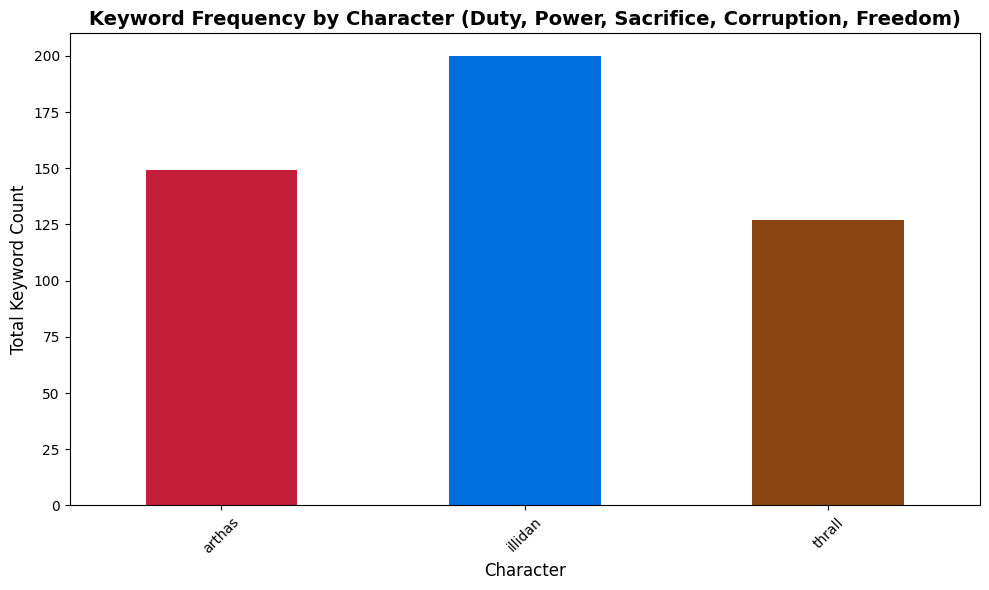


KEYWORD FREQUENCY BY CHARACTER
  Arthas       : 149 keyword occurrences
  Illidan      : 200 keyword occurrences
  Thrall       : 127 keyword occurrences

KEYWORD DISTRIBUTION
  Power           : 349 occurrences
  Sacrifice       :  34 occurrences
  Freedom         :  31 occurrences
  Justice         :  26 occurrences
  Duty            :  21 occurrences
  Corruption      :  15 occurrences




In [17]:
# === ANALYSIS: Keyword Distribution & Visualization ===
print("=" * 60)
print("STEP 3: KEYWORD ANALYSIS & VISUALIZATION")
print("=" * 60)

df = pd.DataFrame(data)

if len(df) > 0:
    print(f"\nAnalyzing {len(df)} passages...")
    
    # Calculate keyword frequency
    df['count'] = df['keywords'].apply(len)
    dense_passages = df[df['count'] >= 1]  # No limit - use ALL passages with keywords
    
    # Show data source breakdown
    print("\nData sources:")
    pdf_count = len(dense_passages[dense_passages['source'].str.contains('.pdf', na=False)])
    web_count = len(dense_passages) - pdf_count
    print(f"  📄 PDF novels: {pdf_count} passages")
    print(f"  🌐 Web (Wowpedia/Wowhead): {web_count} passages")
    
    # Export for qualitative coding
    dense_passages.to_csv('warcraft_passages.csv', index=False)
    print(f"\n✓ Exported {len(dense_passages)} passages → warcraft_passages.csv")
    
    # Generate visualization
    print("\nGenerating keyword frequency chart...")
    char_counts = dense_passages.groupby('char')['count'].sum()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    char_counts.plot.bar(ax=ax, color=['#C41E3A', '#0070DE', '#8B4513'])
    ax.set_title('Keyword Frequency by Character (Duty, Power, Sacrifice, Corruption, Freedom)', 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Total Keyword Count', fontsize=12)
    ax.set_xlabel('Character', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig('keyword_frequency.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 40)
    print("KEYWORD FREQUENCY BY CHARACTER")
    print("=" * 40)
    for char, count in char_counts.items():
        print(f"  {char.capitalize():12} : {count:3} keyword occurrences")
    print("=" * 40)
    
    # Keyword breakdown
    print("\n" + "=" * 40)
    print("KEYWORD DISTRIBUTION")
    print("=" * 40)
    all_keywords = [kw for keywords in df['keywords'] for kw in keywords]
    keyword_counts = Counter(all_keywords)
    for kw, count in keyword_counts.most_common():
        print(f"  {kw.capitalize():15} : {count:3} occurrences")
    print("=" * 40)
    
else:
    print("\n✗ No data collected - check URLs and connection")

print("\n" + "=" * 60 + "\n")

## Thematic Clustering

Groups passages into clusters to identify philosophical patterns (Stoic duty vs. Cynic freedom vs. Tyrant power).

In [18]:
# === ANALYSIS: Text Clustering (Thematic Patterns) ===
print("=" * 60)
print("STEP 4: THEMATIC CLUSTERING ANALYSIS")
print("=" * 60)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

if len(dense_passages) > 0:
    print(f"\nClustering {len(dense_passages)} passages into 3 thematic groups...")
    
    # Vectorize text using TF-IDF
    vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
    X = vectorizer.fit_transform(dense_passages['text'])
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    dense_passages['cluster'] = kmeans.fit_predict(X)
    
    print("✓ Clustering complete\n")
    
    # Display sample passages from each cluster
    print("=" * 60)
    print("SAMPLE PASSAGES BY THEMATIC CLUSTER")
    print("=" * 60)
    
    for cluster_id in range(3):
        print(f"\n--- CLUSTER {cluster_id} ---")
        cluster_passages = dense_passages[dense_passages['cluster'] == cluster_id]
        cluster_size = len(cluster_passages)
        print(f"Size: {cluster_size} passages")
        
        if cluster_size > 0:
            # Show character distribution in cluster
            char_dist = cluster_passages['char'].value_counts()
            print(f"Characters: {dict(char_dist)}")
            
            # Show top keywords in cluster
            cluster_keywords = [kw for keywords in cluster_passages['keywords'] for kw in keywords]
            top_keywords = Counter(cluster_keywords).most_common(3)
            print(f"Top keywords: {', '.join([kw for kw, _ in top_keywords])}")
            
            # Show sample passage
            sample = cluster_passages.iloc[0]
            print(f"\nSample passage ({sample['char']}):")
            print(f"  {sample['text'][:200]}...")
    
    print("\n" + "=" * 60)
    
    # Export clustered data
    dense_passages.to_csv('warcraft_passages_clustered.csv', index=False)
    print("\n✓ Exported clustered data → warcraft_passages_clustered.csv")
    
    # Cluster distribution
    print("\nCluster distribution:")
    print(dense_passages.groupby(['cluster', 'char']).size().unstack(fill_value=0))
    
else:
    print("\n⚠ No passages available for clustering")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)
print("\n📊 Output files generated:")
print("  • warcraft_passages.csv - All extracted passages")
print("  • warcraft_passages_clustered.csv - With cluster assignments")
print("  • keyword_frequency.png - Visualization chart")
if SELENIUM_AVAILABLE:
    print("  • wowhead_quests_selenium.csv - Quest data (if Selenium ran)")
print("\n✅ Ready for qualitative coding in your philosophical archetype analysis!")
print("=" * 60)

STEP 4: THEMATIC CLUSTERING ANALYSIS

Clustering 431 passages into 3 thematic groups...
✓ Clustering complete

SAMPLE PASSAGES BY THEMATIC CLUSTER

--- CLUSTER 0 ---
Size: 88 passages
Characters: {'thrall': np.int64(86), 'arthas': np.int64(2)}
Top keywords: power, freedom, corruption

Sample passage (thrall):
  Thrall was captured and taken to an internment camp run by one Lorin Remka. It was here that he met an old orc with glowing red eyes named Kelgar, who told him of the corruption of Gul'dan, and how th...

--- CLUSTER 1 ---
Size: 226 passages
Characters: {'illidan': np.int64(176), 'thrall': np.int64(32), 'arthas': np.int64(18)}
Top keywords: power, sacrifice, justice

Sample passage (illidan):
  “There is no sacrifice too great if it brings an end to the Burning Legion.”
...

--- CLUSTER 2 ---
Size: 117 passages
Characters: {'arthas': np.int64(116), 'thrall': np.int64(1)}
Top keywords: power, duty, sacrifice

Sample passage (arthas):
  Despite his promising beginnings, Arthas bec

MEDIA TYPE ANALYSIS - Trait Density by Medium

✓ Using in-memory data: 431 passages
Available columns: ['char', 'source', 'text', 'keywords', 'context', 'count', 'cluster']

DATA BREAKDOWN BY MEDIA TYPE
  Gameplay/Lore        : 118 passages
  Cinematics           :   2 passages
  Novels               : 311 passages

KEYWORD DENSITY BY MEDIA TYPE
(Average keywords per passage)
keywords_list  corruption  duty  freedom  justice  power  sacrifice
media                                                              
Cinematics           0.00  0.50     0.00     0.00   0.50       0.00
Gameplay/Lore        0.08  0.04     0.04     0.07   0.75       0.09
Novels               0.02  0.05     0.08     0.06   0.84       0.07


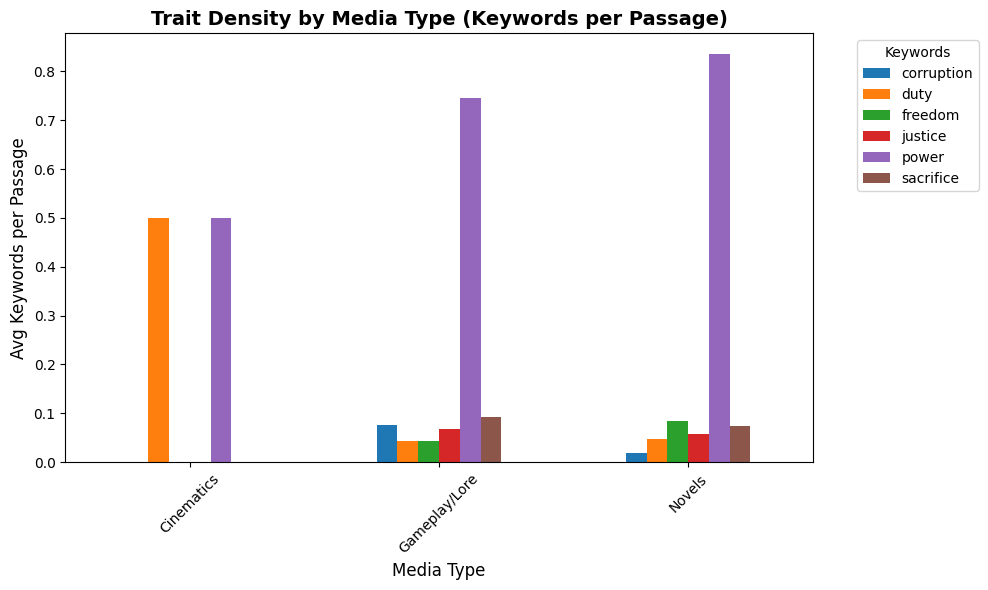


✓ Visualization saved: trait_density_media.png


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import ast

# === MEDIA TYPE ANALYSIS ===
print("=" * 60)
print("MEDIA TYPE ANALYSIS - Trait Density by Medium")
print("=" * 60)

# Check if we have clustered passages from previous analysis
try:
    # Try to use the in-memory DataFrame first
    if 'dense_passages' in globals() and len(dense_passages) > 0:
        df = dense_passages.copy()
        print(f"\n✓ Using in-memory data: {len(df)} passages")
    else:
        # Fall back to reading CSV
        df = pd.read_csv('warcraft_passages_clustered.csv')
        print(f"\n✓ Loaded from CSV: {len(df)} passages")
    
    # Check what columns exist
    print(f"Available columns: {df.columns.tolist()}")
    
    # Verify we have the required columns
    required_cols = ['source', 'keywords', 'char']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"\n✗ Error: Missing required columns: {missing_cols}")
        print("  Please run the data collection and clustering cells first (cells 3-17)")
        raise ValueError("Required columns missing from dataset")
    
    # Categorize media from source URLs (PDFs=novels, wowpedia=game/cinematics)
    def get_media(source):
        if pd.isna(source):
            return 'Other'
        if 'PDF' in source or '.pdf' in source: 
            return 'Novels'
        if 'wowpedia' in source.lower(): 
            if any(word in source.lower() for word in ['cinematic', 'fallofthelichking', 'wrath']):
                return 'Cinematics'
            return 'Gameplay/Lore'  # Quests, wiki lore
        return 'Other'
    
    df['media'] = df['source'].apply(get_media)
    
    # Keywords & counts - handle both list objects and string representations
    def count_keywords(kw_data):
        if isinstance(kw_data, list):
            return len(kw_data)
        elif isinstance(kw_data, str):
            try:
                return len(ast.literal_eval(kw_data))
            except:
                return 0
        return 0
    
    df['keyword_count'] = df['keywords'].apply(count_keywords)
    df['keyword_count'] = df['keywords'].apply(count_keywords)
    
    # Show data breakdown
    print("\n" + "=" * 40)
    print("DATA BREAKDOWN BY MEDIA TYPE")
    print("=" * 40)
    for media_type in df['media'].unique():
        count = len(df[df['media'] == media_type])
        print(f"  {media_type:20} : {count:3} passages")
    print("=" * 40)
    
    # Pivot: Avg density (keywords per passage) by media/keyword
    # First, parse keywords properly to create individual rows per keyword
    def parse_keywords(kw_data):
        if isinstance(kw_data, list):
            return kw_data
        elif isinstance(kw_data, str):
            try:
                return ast.literal_eval(kw_data)
            except:
                return []
        return []
    
    # Explode keywords to get one row per keyword occurrence
    df['keywords_list'] = df['keywords'].apply(parse_keywords)
    df_exploded = df.explode('keywords_list')
    
    # Calculate average density by media type and keyword
    pivot = df_exploded.groupby(['media', 'keywords_list']).size().unstack(fill_value=0)
    
    # Convert to float before normalization to avoid dtype errors
    pivot = pivot.astype(float)
    
    # Normalize by number of passages in each media type to get average density
    for media_type in pivot.index:
        num_passages = len(df[df['media'] == media_type])
        pivot.loc[media_type] = pivot.loc[media_type] / num_passages
    
    print("\n" + "=" * 40)
    print("KEYWORD DENSITY BY MEDIA TYPE")
    print("(Average keywords per passage)")
    print("=" * 40)
    print(pivot.round(2))
    print("=" * 40)
    
    # Plot (novels highest density)
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot.plot(kind='bar', ax=ax)
    ax.set_title('Trait Density by Media Type (Keywords per Passage)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Avg Keywords per Passage', fontsize=12)
    ax.set_xlabel('Media Type', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Keywords', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('trait_density_media.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Visualization saved: trait_density_media.png")
    print("=" * 60)
    
except FileNotFoundError:
    print("\n✗ Error: 'warcraft_passages_clustered.csv' not found")
    print("  Please run the data collection and clustering cells first (cells 3-17)")
except Exception as e:
    print(f"\n✗ Error during media analysis: {e}")
    print("  Please ensure the previous cells have been executed successfully")
